## Wongee Hong, Lennart Vetter, Myisha Hassan

## Project 4: Gaussian Processes and kernel methods
Due October 30, 2025 9:00 AM
Instructions


- Re-do the second part of your linear regression assignment (i.e. the replication of figure 3.8) with Gaussian processes. This basically involves replacing your prediction equations (3.58 and 3.59) with the GP predictions (6.66 and 6.67). Use the Gaussian kernel (eqn 6.23) to build the covariance matrix C (eqn 6.62)

- Stretch goal, 5 points. Read the Practical Guide to Support Vector Classification paper, implement the grid search procedure on the same datasets you used for project 3

## Figure 3.8

Linear Regression using Gaussian Processes

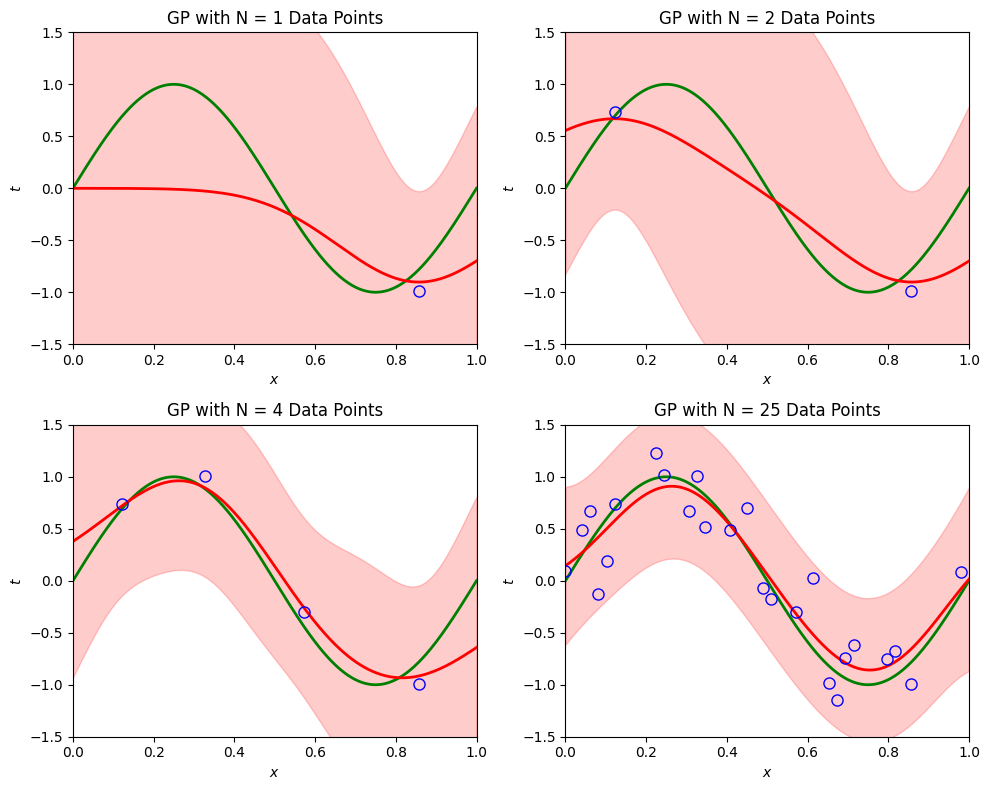

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Process Hyperparameters
beta = 10.0   # noise precision (1 / noise_variance). larger beta = less noise
sigma = 0.2   # length-scale (kernel width to control smoothness)

# GP Kernel Function (eq. 6.23, unit amplitude)
# k(x, x') = exp(- ||x - x'||^2 / (2 * sigma^2))
def gaussian_kernel(x1, x2, sigma):

    # Squared Euclidean Distance x1^2+x^2-2ab
    sq_dist = (
        np.sum(x1**2, axis=1)[:, np.newaxis]  # (N, 1)
        + np.sum(x2**2, axis=1)               # (M,)
        - 2 * np.dot(x1, x2.T)                # (N, M)
    )
    # Apply the guassian RBF formula elementwise
    return np.exp(-sq_dist / (2 * sigma**2))

# Covariance matrix C = K + (1/beta) * I (eq. 6.62)
def build_covariance_matrix_C(Inputs, beta, sigma):

    # K is the N x N Gram matrix of kernel values on training inputs
    K = gaussian_kernel(Inputs, Inputs, sigma)
    # Add noise variance term to the diagonal
    N = len(Inputs)
    C = K + (1.0 / beta) * np.identity(N)
    return C # shape (N, N)

# Compute GP predictive mean and variance at test points (Equations 6.66 & 6.67)
def calculate_predictive_distribution(Inputs, Targets, Plot_Grid, beta, sigma):

    N = len(Inputs)           # number of training points
    M = Plot_Grid.shape[0]    # number of test points

    # If we have no training data, the GP prior says:
    # mean = 0, variance = k(x,x) + 1/beta = 1 + 1/beta (for unit-amplitude RBF).
    if N == 0:
        m = np.zeros(M)
        v = np.full(M, 1.0 + 1.0 / beta)
        return m, v

    # 1) Build training covariance C and invert it
    C = build_covariance_matrix_C(Inputs, beta, sigma)  # (N, N)
    C_inv = np.linalg.inv(C)                            # (N, N)

    # Expand plot points to for x coordinate dimension
    x_plot = np.atleast_2d(Plot_Grid).T

    # 2) Calculcate k, vector of covariances between training points X_data and test point x
    k = gaussian_kernel(Inputs, Plot_Grid, sigma)       # (N, M)

    # 3) c, variance of the prior at test points. For unit-amplitude RBF, k(x,x)=1
    # c(x, x) = k(x, x) + 1/beta = = 1 + 1/beta
    c = 1.0 + (1.0 / beta) # scalar that will broadcast to length M

    # Predictive Mean (Eq. 6.66)
    predictive_mean = k.T @ C_inv @ Targets # shape (M,)

    # 5. Predictive Variance (Eq. 6.67): sigma^2(x_N+1) = c - k.T @ C_inv @ k
    k_T_C_inv_k_matrix = k.T @ C_inv @ k # compute the full (M x M)
    k_T_C_inv_k = np.diag(k_T_C_inv_k_matrix) # Take diagonal
    predictive_variance = c - k_T_C_inv_k

    return predictive_mean, predictive_variance

def true_function(x):
    return np.sin(2 * np.pi * x)  # smooth periodic function on [0, 1]

def generate_sinusoid_data(num_points, beta, seed=42):
    rng = np.random.default_rng(seed)
    X = np.linspace(0, 1, num_points)
    X = X[:, np.newaxis] # make it (N, 1) so our kernel expects 2D inputs
    noise = rng.normal(0.0, 1.0 / np.sqrt(beta), size=num_points)
    T = true_function(X.flatten()) + noise # Targets: true value + noise
    # Shuffle the order of points so we can reveal "random" subsets later
    idx = np.arange(num_points)
    rng.shuffle(idx)
    return X[idx], T[idx]

# Incremental data sizes for 4 panels
data_points_to_observe = [1, 2, 4, 25]

# Generate a pool of 50 noisy samples and then reveal the first N points for each panel
X_all, T_all = generate_sinusoid_data(num_points=50, beta=beta)
X_data = np.empty((0, 1))   # start with no training inputs
T_data = np.array([])       # start with no training targets

# Set up figure and a grid of test x-values to draw predictive curves
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
x_plot = np.linspace(0, 1, 300)
x_plot_gp = x_plot[:, np.newaxis] # Ensure x_plot is (M, 1) for the kernel

current_data_idx = 0  # how many points we’ve revealed so far

for i, N_target in enumerate(data_points_to_observe):
    ax = axes[i]

    # Get the new data chunk up to N_target for this panel
    num_new_points = N_target - current_data_idx
    if num_new_points > 0:
        # Take the next chunk of shuffled points
        x_new = X_all[current_data_idx:N_target]
        t_new = T_all[current_data_idx:N_target]

        # Append them to our running training set
        X_data = np.vstack([X_data, x_new]) if X_data.size else x_new
        T_data = np.append(T_data, t_new)

        current_data_idx = N_target

    # Calculate GP Predictive Distribution using GP equations
    mean, variance = calculate_predictive_distribution(X_data, T_data, x_plot_gp, beta, sigma)
    std_dev = np.sqrt(variance)

    # Plot
    ax.plot(x_plot, true_function(x_plot), 'g-', linewidth=2, label='True Function')
    ax.plot(x_plot, mean, 'r-', linewidth=2, label='Predictive Mean')
    ax.fill_between(x_plot, mean - 2 * std_dev, mean + 2 * std_dev,
                      color='r', alpha=0.2, label=r'$\pm2\sigma$')
    ax.plot(X_data.flatten(), T_data, 'bo', markerfacecolor='none', markersize=8)
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_title(f'GP with N = {len(X_data)} Data Points')

plt.tight_layout()
plt.show()

## Stretch Goal: Support Vector Machine

Synthetic 2D data

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# define variables
mu1 = np.array([1,1])
mu2 = np.array([-1,-1])
sigma = np.eye(2) # covariance matrix that controls spread and orientation of data cloud
# in this case, since sigma = identity matrix, it forms perfect circle cloud
N = 200 # number of data points
np.random.seed(0)

# # Generate two Gaussian clusters
x1 = np.random.multivariate_normal(mu1, sigma, N) # Class 1 samples
x2 = np.random.multivariate_normal(mu2, sigma, N) # Class 0 samples

# Combine data and create labels
X = np.vstack((x1, x2))
t = np.hstack((np.ones(N), np.zeros(N)))

# Set Up SVM Pipeline and CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

pipe = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("svc", SVC(kernel="rbf"))
])

# --- Run Coarse Grid Search ---

# Define exponential search grids (powers of 2) for C and gamma
C_coarse = [2.0 ** p for p in range(-5, 16, 2)]
gamma_coarse = [2.0 ** p for p in range(-15, 4, 2)]
param_grid_coarse = {"svc__C": C_coarse, "svc__gamma": gamma_coarse}

# Perform coarse grid search with 5-fold cross-validation
grid_coarse = GridSearchCV(pipe, param_grid_coarse, scoring="accuracy", cv=cv, n_jobs=-1)
grid_coarse.fit(X, t)

best_coarse_params = grid_coarse.best_params_
best_coarse_score = grid_coarse.best_score_

print("\n--- Coarse Grid Search Results on Synthetic Data ---")
print(f"Best Cross-Validation Accuracy (Coarse): {best_coarse_score:.4f}")
print(f"Best Hyperparameters (Coarse): {best_coarse_params}")

# --- Fine grid search around the coarse best parameters ---

# Retrieve the best coarse-grid parameters
best_C = grid_coarse.best_estimator_.named_steps["svc"].C
best_gamma = grid_coarse.best_estimator_.named_steps["svc"].gamma

# Build finer grid search region +/-1 exponent around the best log2 values
C_fine = [2.0 ** p for p in np.linspace(np.log2(best_C) - 1, np.log2(best_C) + 1, 5)]
gamma_fine = [2.0 ** p for p in np.linspace(np.log2(best_gamma) - 1, np.log2(best_gamma) + 1, 5)]
param_grid_fine= {"svc__C": C_fine, "svc__gamma": gamma_fine}

# Perform fine grid search to refine optimal region
grid_fine = GridSearchCV(pipe, param_grid_fine, scoring="accuracy", cv=cv, n_jobs=-1)
grid_fine.fit(X, t)

best_fine_params = grid_fine.best_params_
best_fine_score = grid_fine.best_score_

print("\n--- Fine Grid Search Results on Synthetic Data ---")
print(f"Best Cross-Validation Accuracy (Fine): {best_fine_score:.4f}")
print(f"Best Hyperparameters (Fine): { {k: float(v) for k, v in best_fine_params.items()} }")


--- Coarse Grid Search Results on Synthetic Data ---
Best Cross-Validation Accuracy (Coarse): 0.9250
Best Hyperparameters (Coarse): {'svc__C': 0.03125, 'svc__gamma': 3.0517578125e-05}

--- Fine Grid Search Results on Synthetic Data ---
Best Cross-Validation Accuracy (Fine): 0.9250
Best Hyperparameters (Fine): {'svc__C': 0.015625, 'svc__gamma': 1.52587890625e-05}


## Stretch Goal: SVM for Ads Dataset

The data is freely availabe at: https://www.kaggle.com/datasets/mdwasimakhtar03/social-network-adscsv

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Extract features (Age and Estimated Salary) and target (Purchased: 0=No, 1=Yes)
df = pd.read_csv("/content/Social_Network_Ads.csv")
Xk = df[['Age', 'EstimatedSalary']].to_numpy(dtype=float)
tk = df['Purchased'].to_numpy(dtype=int)

# Split data into training and testing sets
# We train on 70% of data and test on remaining 30% to see how well we generalize
X_train_k, X_test_k, t_train_k, t_test_k = train_test_split(
    Xk, tk, test_size=0.30, random_state=0, stratify=tk)

# Pipeline & CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
pipe = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("svc", SVC(kernel="rbf"))
])

# Coarse Grid Search (Training CV)
# Define exponential search grids (powers of 2) for C and gamma
C_coarse = [2.0 ** p for p in range(-5, 16, 2)]
gamma_coarse = [2.0 ** p for p in range(-15, 4, 2)]
param_grid_coarse = {"svc__C": C_coarse, "svc__gamma": gamma_coarse}

## Perform coarse grid search using 5-fold cross-validation on training data
grid_coarse = GridSearchCV(pipe, param_grid_coarse, scoring="accuracy", cv=cv, n_jobs=-1)
grid_coarse.fit(X_train_k, t_train_k)

# Extract best hyperparameters and cross-validation score
best_params_coarse = grid_coarse.best_params_
best_score_coarse = grid_coarse.best_score_
best_model_coarse = grid_coarse.best_estimator_

# Evaluate coarse-best model on the unseen TEST set
t_pred_coarse = best_model_coarse.predict(X_test_k)
test_acc_coarse = accuracy_score(t_test_k, t_pred_coarse)

print("\n--- Coarse Grid Search (Social_Network_Ads) ---")
print(f"Best CV Accuracy (Coarse): {best_score_coarse:.4f}")
print(f"Best Params (Coarse): {best_params_coarse}")
print(f"Test Accuracy (Coarse-best): {test_acc_coarse:.4f}")

# Fine Grid Search (Training CV): zoom around coarse-best in log2 space

# Retrieve best parameters from coarse search
best_C = best_model_coarse.named_steps["svc"].C
best_gamma = best_model_coarse.named_steps["svc"].gamma

# Define finer search region: ±1 exponent around coarse-best log2 values
C_fine = [2.0 ** p for p in np.linspace(np.log2(best_C) - 1, np.log2(best_C) + 1, 5)]
gamma_fine = [2.0 ** p for p in np.linspace(np.log2(best_gamma) - 1, np.log2(best_gamma) + 1, 5)]
param_grid_fine = {"svc__C": C_fine, "svc__gamma": gamma_fine}

# Perform fine grid search to refine optimal hyperparameters
grid_fine = GridSearchCV(pipe, param_grid_fine, scoring="accuracy", cv=cv, n_jobs=-1)
grid_fine.fit(X_train_k, t_train_k)

# Extract fine-tuned best parameters and cross-validation score
best_params_fine = grid_fine.best_params_
best_score_fine = grid_fine.best_score_
best_model_fine = grid_fine.best_estimator_

# Evaluate fine-best model on TEST data
t_pred_fine = best_model_fine.predict(X_test_k)
test_acc_fine = accuracy_score(t_test_k, t_pred_fine)

print("\n--- Fine Grid Search (Social_Network_Ads) ---")
print(f"Best CV Accuracy (Fine): {best_score_fine:.4f}")
print(f"Best Params (Fine): { {k: float(v) for k, v in best_params_fine.items()} }")
print(f"Test Accuracy (Fine-best): {test_acc_fine:.4f}")


--- Coarse Grid Search (Social_Network_Ads) ---
Best CV Accuracy (Coarse): 0.9214
Best Params (Coarse): {'svc__C': 8.0, 'svc__gamma': 2.0}
Test Accuracy (Coarse-best): 0.8917

--- Fine Grid Search (Social_Network_Ads) ---
Best CV Accuracy (Fine): 0.9214
Best Params (Fine): {'svc__C': 5.656854249492381, 'svc__gamma': 1.4142135623730951}
Test Accuracy (Fine-best): 0.8917
